In [1]:
import numpy as np
import json
from livecell_tracker.core import (
    SingleCellTrajectory,
    SingleCellStatic,
    SingleCellTrajectoryCollection,
)
from livecell_tracker.segment.detectron_utils import (
    convert_detectron_instance_pred_masks_to_binary_masks,
    convert_detectron_instances_to_label_masks,
    segment_images_by_detectron,
    segment_single_img_by_detectron_wrapper,
)
from livecell_tracker.core.datasets import LiveCellImageDataset
from livecell_tracker.preprocess.utils import (
    overlay,
    enhance_contrast,
    normalize_img_to_uint8,
)
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from pathlib import Path

## Convert Labelme Json to COCO Json

run the following code once for generating coco json
```
import livecell_tracker.segment
import livecell_tracker.annotation
import livecell_tracker.annotation.labelme2coco
import os
labelme_json_folder = r"""../datasets/a549_ccnn/annotation_data"""
dataset_folder_path = r"""../datasets/a549_ccnn/original_data"""
export_dir = "./notebook_results/correction_cnn_v0.0.0/"
os.makedirs(export_dir, exist_ok=True)
livecell_tracker.annotation.labelme2coco.convert(
    labelme_json_folder,
    export_dir,
    train_split_rate=0.9,
    dataset_folder_path=dataset_folder_path,
    # is_image_in_json_folder=True,
    image_file_ext="tif",
    # image_file_ext="png",
)
```

## Load COCO into SingleCell Objects

In [2]:
from pycocotools.coco import COCO

coco_data = COCO("../datasets/a549_ccnn/a549_ccnn_coco_v0.0.0/train.json")
out_dir = Path("./notebook_results/a549_ccp_vim/train_data_v5/")

coco_data.anns.keys(), coco_data.anns[1].keys(), coco_data.anns[1]["segmentation"][0][
    :5
]


loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 2

In [3]:
coco_data.imgs.keys(), coco_data.imgs[1].keys(), coco_data.imgs[1]["file_name"],


(dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59]),
 dict_keys(['height', 'width', 'id', 'file_name']),
 '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile7_DIC-FITC.tif')

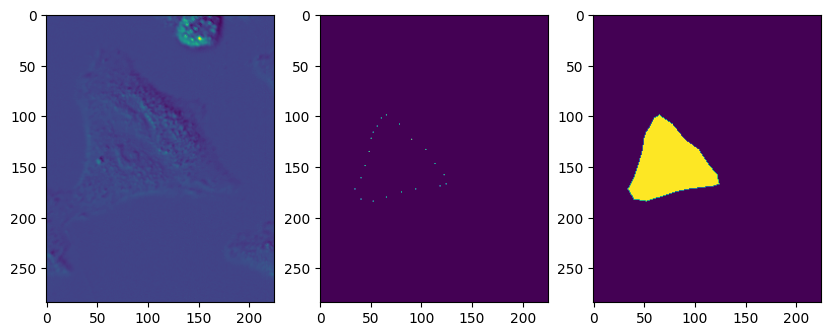

In [4]:
from typing import List

from livecell_tracker.annotation.coco_utils import coco_to_sc

single_cells = coco_to_sc(coco_data)


# for testing
# single_cells = single_cells[:20]

fig, axes = plt.subplots(1, 3, figsize=(10, 5))
cell_id = 10
axes[0].imshow(single_cells[cell_id].get_img_crop(padding=100))
axes[1].imshow(single_cells[cell_id].get_contour_mask_closed_form(padding=100))
axes[2].imshow(single_cells[cell_id].get_contour_mask(padding=100))


In [5]:
len(single_cells)

294

save a list of single cell objects

In [6]:
SingleCellStatic.write_single_cells_json(
    single_cells, "../datasets/a549_ccnn/single_cells.json"
)


In [7]:
contour_mask = single_cells[cell_id].get_contour_mask(padding=100)
contour_mask.astype(np.uint8)


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

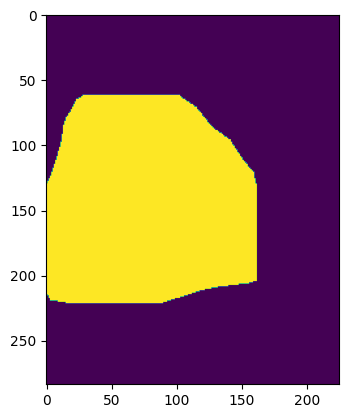

In [8]:
import cv2 as cv
from livecell_tracker.preprocess.utils import dilate_or_erode_mask

plt.imshow(dilate_or_erode_mask(contour_mask.astype(np.uint8), 1))


## Compute similarity between manually segmented cell and segmentation results

We will take sample_sc as an example to show how to compute IOU based similarity between manually segmented cell and segmentation results from machine learning models.  
Instead, this part may be done by a human annotator by clicking the corresponding cell in the segmentation results.

In [9]:
sample_sc = single_cells[cell_id]
sample_sc.meta


{'img_id': 7,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile8_DIC-FITC.tif'}

In [10]:
import glob

raw_img_dataset = sample_sc.img_dataset
seg_data_dir = "../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11"
seg_paths = glob.glob(os.path.join(seg_data_dir, "*.png"))
print("sample seg paths:", seg_paths[:2])
matched_time2seg = {}
# for time, img_path in raw_img_dataset.time2url.items():
#     substr = os.path.basename(img_path).split(".")[0]
#     print("substr:", substr)
#     for seg_path
#     break
corrected_indices = []
for seg_path in seg_paths:
    substr = os.path.basename(seg_path).split(".")[0] # get rid of extension
    substr = substr[4:]  # get rid of seg_ prefix
    img, path, index = raw_img_dataset.get_img_by_url(
        substr, return_path_and_time=True, ignore_missing=True
    )
    if path is None:
        print("skip due to substr not found:", substr)
        continue
    matched_time2seg[index] = seg_path

seg_data = LiveCellImageDataset(time2url=matched_time2seg, ext="png")
sample_sc.mask_dataset = seg_data
assert len(seg_data) == len(raw_img_dataset)


sample seg paths: ['../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY2_DIC_tile8_DIC-FITC.png', '../datasets/a549_ccnn/seg_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/seg_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile0_DIC-FITC.png']
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY1_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY2_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T13_XY4_DIC_tile1_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T01_XY1_DIC_tile4_DIC-FITC
skip due to substr not found: CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY4_DIC_tile2_DIC-FITC
skip due to substr not fo

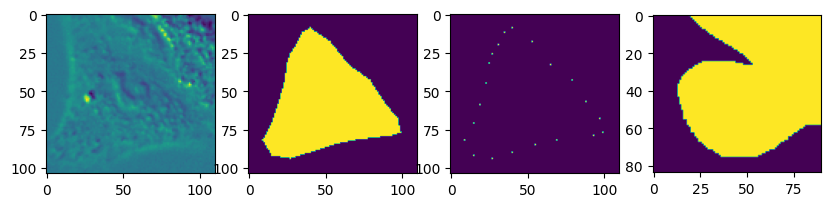

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
axes[0].imshow(sample_sc.get_img_crop(padding=10))
axes[1].imshow(sample_sc.get_contour_mask(padding=10))
axes[2].imshow(sample_sc.get_contour_mask_closed_form(padding=10))
axes[3].imshow(sample_sc.get_mask_crop())


Show a sample whole image with code below

```
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
ax.imshow(sample_sc.get_img())
```


In [12]:
seg_mask = seg_data.get_img_by_url(
    os.path.basename(sample_sc.meta["path"]).split(".")[0], substr=True
)


In [13]:
np.max(seg_mask.flatten())


59

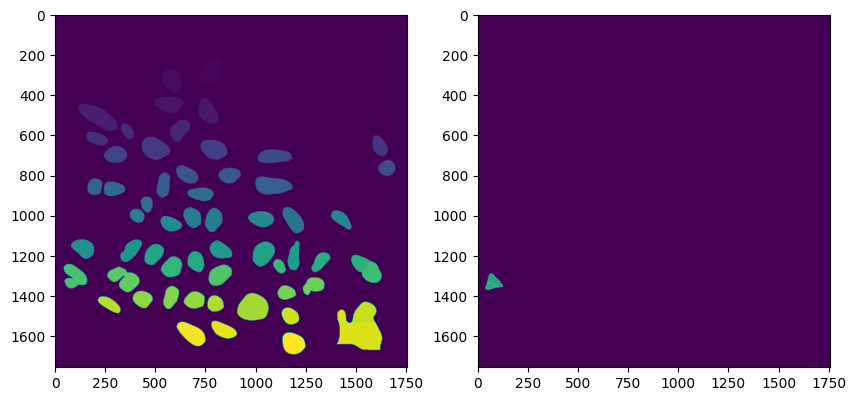

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes[0].imshow(seg_mask)
axes[1].imshow(sample_sc.get_contour_img(crop=False))


Text(0.5, 1.0, 'ground truth')

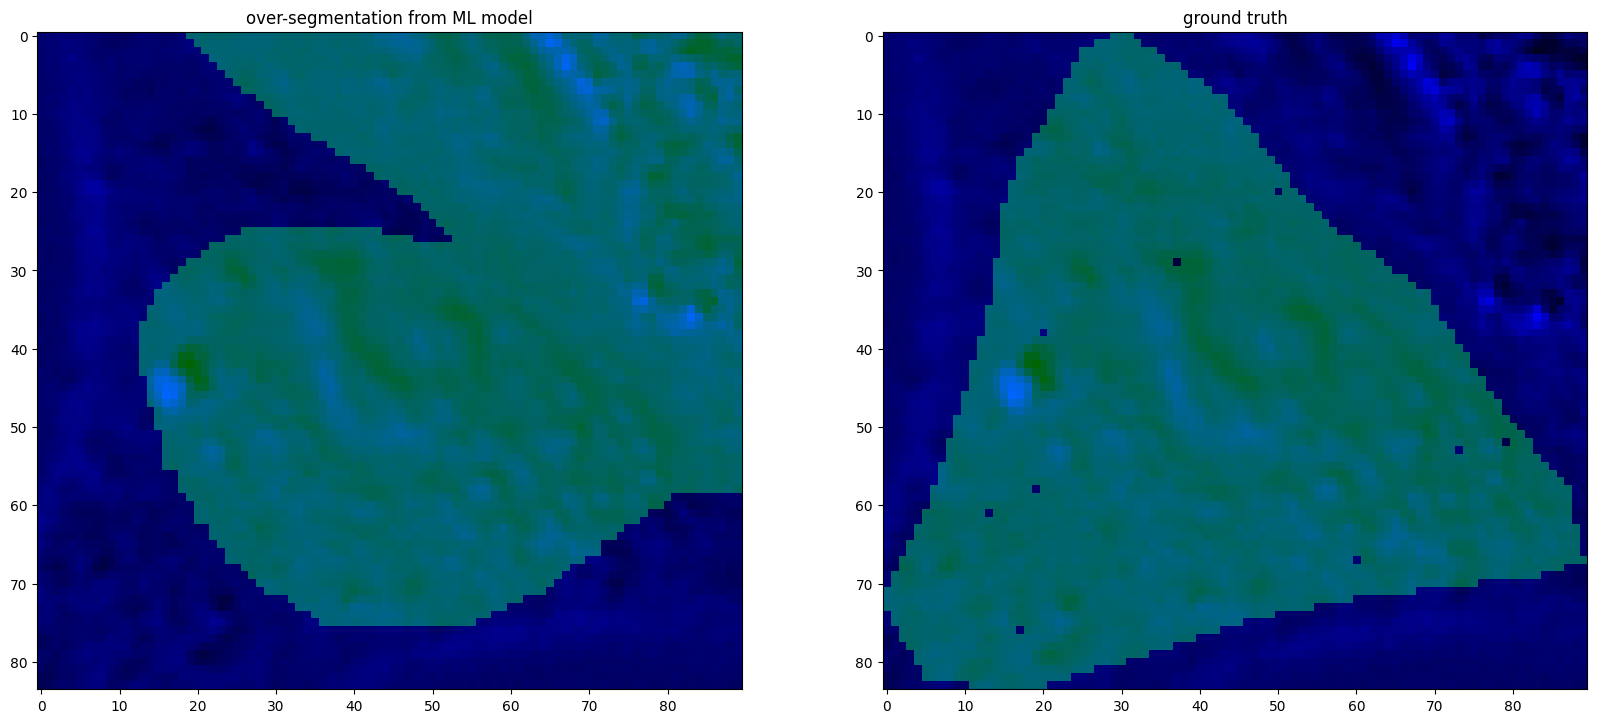

In [15]:
cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sample_sc.bbox, seg_mask)
fig, axes = plt.subplots(1, 2, figsize=(20, 10))
axes[0].imshow(
    overlay(sample_sc.get_img_crop(), cropped_seg_mask, img_channel_rgb_val_factor=1)
)
axes[0].set_title("over-segmentation from ML model")
axes[1].imshow(
    overlay(
        sample_sc.get_img_crop(),
        sample_sc.get_contour_img(),
        img_channel_rgb_val_factor=1,
    )
)
axes[1].set_title("ground truth")


In [16]:
from livecell_tracker.segment.utils import match_mask_labels_by_iou

match_mask_labels_by_iou(cropped_seg_mask, sample_sc.get_contour_mask())


{True: {'best_iou': 0.49522693016245184, 'seg_label': 42}}

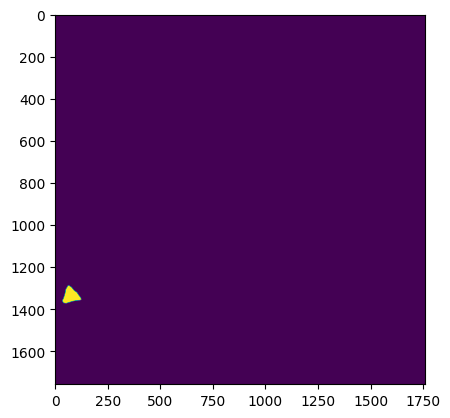

In [17]:
plt.imshow(sample_sc.get_contour_mask(crop=False))


Text(0.5, 1.0, 'T07 XY4 TILE7 seg overlay')

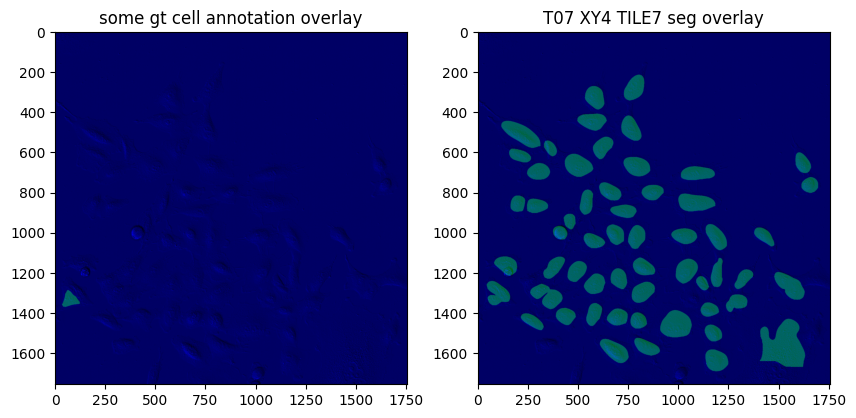

In [18]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))
axes[0].imshow(
    overlay(
        enhance_contrast(normalize_img_to_uint8(sample_sc.get_img()), factor=0.5),
        sample_sc.get_contour_mask(crop=False),
        img_channel_rgb_val_factor=2,
    )
)
axes[0].set_title("some gt cell annotation overlay")
axes[1].imshow(
    overlay(
        enhance_contrast(normalize_img_to_uint8(sample_sc.get_img()), factor=0.9),
        seg_mask,
        img_channel_rgb_val_factor=2,
    )
)
axes[1].set_title("T07 XY4 TILE7 seg overlay")


In [19]:
sample_sc.get_contour_mask()


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

In [20]:
def match_seg_mask_label(mask: np.array, sc: SingleCellStatic):
    """match a single cell's label in a mask. sc must contain its contour information.

    Parameters
    ----------
    mask : np.array
        _description_
    sc : 
        _description_

    Returns
    -------
    a dict with keys "seg_label" and "iou"
    """    
    cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, seg_mask)
    match_res = match_mask_labels_by_iou(cropped_seg_mask, sc.get_contour_mask())
    assert len(match_res) == 1, "Either sc's get contour mask returns a mask with more than 1 gt, or there is some bug in match_mask_labels_by_iou"
    match_res = list(match_res.values())[0]
    return match_res

# example usage
seg_label = match_seg_mask_label(seg_mask, sample_sc)["seg_label"]
seg_label


42

### Compute similarity for all cells and get the mapping between single cells and its corresponding label in the segmentation results

In [21]:
for sc in tqdm(single_cells):
    sc_img_path_substr = os.path.basename(sc.meta["path"]).split(".")[0]
    seg_mask = seg_data.get_img_by_url(sc_img_path_substr, substr=True)
    sc.meta["seg_label"] = match_seg_mask_label(seg_mask, sc)["seg_label"]
    sc.mask_dataset = seg_data


100%|██████████| 294/294 [00:12<00:00, 24.14it/s]


<AxesSubplot: >

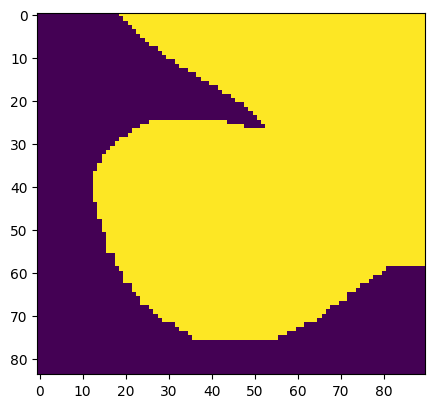

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sample_sc.show_mask()


## Generate dilated and eroded masks for each cell
Create an augmented dataset.
Save results via single cell data structure
```
Single Cell Json metadata
{
    seg_label: 13,
    img_id: 1,
}
```

We pad the each cell mask with a defined background value (0).

In [23]:
len(seg_data), len(sample_sc.img_dataset)


(59, 59)

In [24]:
sample_sc = single_cells[-1]
sample_sc.meta


{'img_id': 59,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
 'seg_label': 16}

## Undersegmentation case: create mapping from seg label id to gt id

In [25]:
single_cells[-1].meta, single_cells[-2].meta

({'img_id': 59,
  'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
  'seg_label': 16},
 {'img_id': 59,
  'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
  'seg_label': 16})

In [26]:
sample_sc.meta

{'img_id': 59,
 'path': '../datasets/a549_ccnn/original_data/dic_tiles_CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11/CCP_A549-VIM_lessThan24hr_Calcein_1mg-ml_DP_Ti2e_2022-9-11_T07_XY3_DIC_tile6_DIC-FITC.tif',
 'seg_label': 16}

In [27]:
seg2scs = {}
for sc in single_cells:
    seg_label = sc.meta["seg_label"]
    img_id = sc.meta["img_id"]
    key = (img_id, seg_label)
    if key not in seg2scs:
        seg2scs[key] = []
    seg2scs[key].append(sc)

Count how many simple undersegmentation there are in our dataset

In [28]:
underseg_cases = {key: val for key, val in seg2scs.items() if len(val) > 1}
len(underseg_cases)

56

Visualize one such undersegmentation case

In [29]:
# choose any case
underseg_case = list(underseg_cases.items())[2]
underseg_case

((5, 11),
  <livecell_tracker.core.single_cell.SingleCellStatic at 0x7f915f42e4a0>])

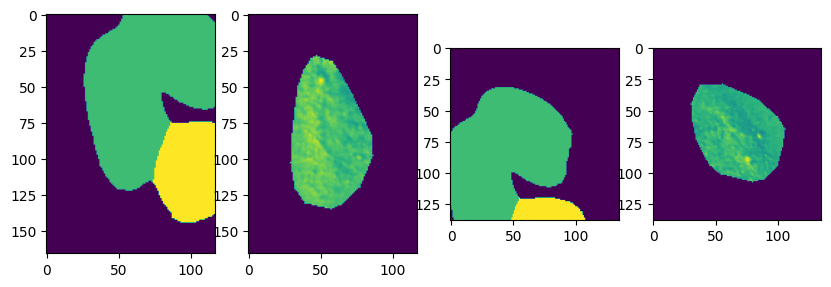

In [30]:
fig, axes = plt.subplots(1, 4, figsize=(10, 5))
underseg_scs = underseg_case[1]
padding = 30
axes[0].imshow(underseg_scs[0].get_mask_crop(padding=padding))
axes[1].imshow(underseg_scs[0].get_contour_img(padding=padding))
axes[2].imshow(underseg_scs[1].get_mask_crop(padding=padding))
axes[3].imshow(underseg_scs[1].get_contour_img(padding=padding))


### Augment undersegmentation case  
sc.mask_dataset, sc.get_mask(): from seg_mask  
sc.bbox, sc.contour, sc.get_contour(): from gt


In [31]:
from typing import Tuple
from skimage.measure import regionprops
import pandas as pd
from livecell_tracker.core.io_utils import save_tiff


def underseg_overlay_gt_masks(
    seg_label: int, scs: SingleCellStatic, padding_scale=1.5, seg_mask=None
) -> Tuple[np.array, np.array, np.array]:
    """Overlay segmentation masks and ground truth masks for under-segmentation cases.
    Specifically, for a segmentation label, if there are multiple ground truth masks matched to it,
    then we overlay ground truths masks in the same kmask

    Parameters
    ----------
    seg_label : int
        _description_
    scs : SingleCellStatic
        _description_
    padding_scale : float, optional
        _description_, by default 1.5
    mask :
        if not None, use the mask, otherwise inferred from other args, by default None

    Returns
    -------
    Tuple[np.array, np.array, np.array]
        (img_crop, seg_crop, combined ground-truth mask)
    """
    if len(scs) == 0:
        print("no scs for this seg_label")
        return None, None, None

    if seg_mask is None:
        seg_mask = scs[0].get_mask()

    seg_mask[seg_mask != seg_label] = 0
    props_list = regionprops(seg_mask)

    if len(props_list) != 1:
        print(
            "[WARNING] skip: (%d, %d) due to more than one region found in seg mask or NO region found in seg mask"
            % (img_id, seg_label)
        )
        return
    # obtain segmentation bbox from segmentation mask
    seg_props = props_list[0]
    seg_bbox = seg_props.bbox
    xmin, ymin, xmax, ymax = seg_bbox

    # compute padding based on scale
    padding_pixels = np.array((padding_scale - 1) * max(xmax - xmin, ymax - ymin))
    padding_pixels = padding_pixels.astype(int)

    # get seg mask's crop with single cell's get_mask_crop implementation for consistency
    tmp = np.array(scs[0].bbox)
    scs[0].bbox = seg_bbox
    seg_crop = scs[0].get_mask_crop(padding=padding_pixels)
    scs[0].bbox = np.array(tmp)

    # clear other seg labels
    seg_crop[seg_crop != seg_label] = 0
    seg_crop[seg_crop > 0] = 1

    combined_gt_mask = np.zeros(seg_crop.shape)
    img_crop = None
    for idx, sc in enumerate(scs):
        sc.meta["seg_label"] = None
        tmp = np.array(sc.bbox)
        sc.bbox = seg_bbox
        combined_gt_mask += (idx + 1) * sc.get_contour_mask(padding=padding_pixels)
        img_crop = sc.get_img_crop(padding=padding_pixels) if img_crop is None else img_crop  # set img_crop once
        sc.bbox = tmp
    return (img_crop, seg_crop, combined_gt_mask)


def gen_aug_diff_mask(aug_mask: np.array, combined_gt_mask: np.array) -> np.array:
    """generate a mask based on the difference between the augmented mask and the combined gt mask
    0: no difference
    -1: augmented mask is 0, combined gt mask is 1 -> over-segmentation
    1: augmented mask is 1, combined gt mask is 0 -> under-segmentation
    Note: special care for uint8 case when calculating difference mask if we use cv2 related functions

    Parameters
    ----------
    aug_mask : np.array
        _description_
    combined_gt_mask : np.array
        _description_

    Returns
    -------
    np.array
        _description_
    """
    aug_mask = aug_mask.astype(int)  # prevent uint8 overflow (-1 in diff case below)
    underseg_mask = np.zeros(aug_mask.shape)
    underseg_mask[combined_gt_mask > 0] = 1
    combined_gt_mask = combined_gt_mask.astype(int)
    diff_mask = aug_mask - combined_gt_mask  # should only contain 0 and 1
    assert len(np.unique(diff_mask)) <= 3

    return diff_mask


underseg_seg2scs = underseg_cases

underseg_out_dir = out_dir / "real_underseg_cases"
raw_out_dir = underseg_out_dir / "raw"
seg_out_dir = underseg_out_dir / "seg"
gt_out_dir = underseg_out_dir / "gt"
gt_label_out_dir = underseg_out_dir / "gt_label_mask"
augmented_seg_dir = underseg_out_dir / "augmented_seg"
raw_transformed_img_dir = underseg_out_dir / "raw_transformed_img"
augmented_diff_seg_dir = underseg_out_dir / "augmented_diff_seg"

os.makedirs(raw_out_dir, exist_ok=True)
os.makedirs(seg_out_dir, exist_ok=True)
os.makedirs(gt_out_dir, exist_ok=True)
os.makedirs(augmented_seg_dir, exist_ok=True)
os.makedirs(gt_label_out_dir, exist_ok=True)
os.makedirs(raw_transformed_img_dir, exist_ok=True)
os.makedirs(augmented_diff_seg_dir, exist_ok=True)

scale_factors = np.linspace(0, 0.3, 10)

train_path_tuples = []
augmented_data = []

def csn_augment_helper(
    img_crop,
    seg_crop,
    combined_gt_label_mask,
    scale_factors: list,
    train_path_tuples: list,
    augmented_data: list,
    img_id,
    seg_label,
    gt_label,
    raw_img_path,
    seg_img_path,
    gt_img_path,
    gt_label_img_path,
    augmented_seg_dir,
    augmented_diff_seg_dir,
    filename_pattern="img-%d_seg-%d.tif",
    overseg_raw_seg_crop=None,
    overseg_raw_seg_img_path=None,
):

    combined_gt_binary_mask = combined_gt_label_mask > 0
    combined_gt_binary_mask = combined_gt_binary_mask.astype(np.uint8)

    save_tiff(img_crop, raw_img_path, mode="I")  # save to 32-bit depth signed integer
    save_tiff(seg_crop, seg_img_path)
    save_tiff(combined_gt_binary_mask, gt_img_path)
    save_tiff(combined_gt_label_mask, gt_label_img_path)

    if overseg_raw_seg_img_path is not None:
        save_tiff(overseg_raw_seg_crop, overseg_raw_seg_img_path)

    # append aug-%d to filename pattern
    root, ext = os.path.splitext(filename_pattern)
    aug_filename_pattern = root + "_aug-%d" + ext
    # dilate or erode segmentation mask
    for idx, scale in enumerate(scale_factors):
        augmented_seg_path = augmented_seg_dir / (aug_filename_pattern % (img_id, seg_label, idx))
        augmented_diff_seg_path = augmented_diff_seg_dir / (aug_filename_pattern % (img_id, seg_label, idx))

        if np.unique(seg_crop).shape[0] > 256:
            print("[WARNING] skip: (%d, %d) due to more than 256 unique seg labels" % (img_id, seg_label))
            continue
        seg_crop = seg_crop.astype(np.uint8)

        # seg_crop should only contains one label
        # TODO: the condition commented above should be a postcondition of underseg_overlay_gt_masks
        seg_crop[seg_crop > 0] = 1
        aug_seg_crop = dilate_or_erode_mask(seg_crop, scale_factor=scale)
        aug_values = np.unique(aug_seg_crop)
        assert len(aug_values) <= 2, "only two values should be present in aug masks"
        aug_seg_crop[aug_seg_crop > 0] = 1
        aug_seg_crop[aug_seg_crop < 0] = 0  # not necessary, check math
        save_tiff(aug_seg_crop, augmented_seg_path)

        aug_diff_mask = gen_aug_diff_mask(aug_seg_crop, combined_gt_binary_mask)
        save_tiff(aug_diff_mask, augmented_diff_seg_path, mode="I")

        raw_transformed_img_path = raw_transformed_img_dir / ("img-%d_seg-%d_aug-%d.tif" % (img_id, seg_label, idx))
        raw_transformed_img_crop = img_crop.copy().astype(int)
        raw_transformed_img_crop[aug_seg_crop == 0] *= -1
        save_tiff(raw_transformed_img_crop, raw_transformed_img_path, mode="I")

        train_path_tuples.append(
            (
                raw_img_path.as_posix(),
                augmented_seg_path.as_posix(),
                gt_img_path.as_posix(),
                seg_img_path.as_posix(),
                scale,
                augmented_diff_seg_path.as_posix(),
                gt_label_img_path.as_posix(),
                raw_transformed_img_path.as_posix(),
            )
        )

        augmented_data.append({
            "img_id": img_id,
            "img_crop": img_crop,
            "seg_crop": seg_crop,
            "seg_label": seg_label,
            "gt_label": gt_label,
            "combined_gt_mask": combined_gt_binary_mask,
            "aug_seg_crop": aug_seg_crop,
            "aug_diff_mask": aug_diff_mask,
            "combined_gt_label_mask": combined_gt_label_mask,
            "raw_transformed_img_crop": raw_transformed_img_crop,
        })
        # augmented_data[(img_id, seg_label)].append(
        #     (
        #         img_crop,
        #         seg_crop,
        #         combined_gt_mask,
        #         aug_seg_crop,
        #         aug_diff_mask,
        #         combined_gt_label_mask,
        #         raw_transformed_img_crop,
        #     )
        # )


In [32]:

for img_id, seg_label in tqdm(underseg_seg2scs):
    scs = underseg_seg2scs[(img_id, seg_label)]
    assert len(scs) > 0, "the list of single cells should not be empty"
    
    (img_crop, seg_crop, combined_gt_label_mask) = underseg_overlay_gt_masks(seg_label, scs, padding_scale=2)
    raw_img_path = raw_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))
    seg_img_path = seg_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_img_path = gt_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))
    gt_label_img_path = gt_label_out_dir / ("img-%d_seg-%d.tif" % (img_id, seg_label))

    # call csn augment helper
    csn_augment_helper(img_crop=img_crop, 
        seg_crop=seg_crop, 
        combined_gt_label_mask=combined_gt_label_mask,
        scale_factors=scale_factors,
        train_path_tuples=train_path_tuples,
        augmented_data=augmented_data,
        img_id=img_id,
        seg_label=seg_label,
        gt_label=None,
        raw_img_path=raw_img_path,
        seg_img_path=seg_img_path,
        gt_img_path=gt_img_path,
        gt_label_img_path=gt_label_img_path,
        augmented_seg_dir=augmented_seg_dir,
        augmented_diff_seg_dir=augmented_diff_seg_dir,
    )


pd.DataFrame(
    train_path_tuples,
    columns=["raw", "seg", "gt", "raw_seg", "scale", "aug_diff_mask", "gt_label_mask", "raw_transformed_img"],
).to_csv(underseg_out_dir / "data.csv", index=False)


100%|██████████| 56/56 [00:11<00:00,  4.99it/s]


## Generate oversegmentation cases

In [33]:
class BackgroundSimulator:
    pass

class OverSegSimulator:
    pass

class UnderSegSimulator:
    pass


In [34]:
a = np.array([[1, 2], [3, 4]])
a[(1,1), (0,0)]

array([3, 3])

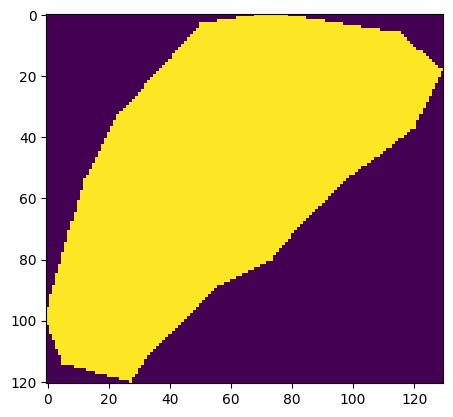

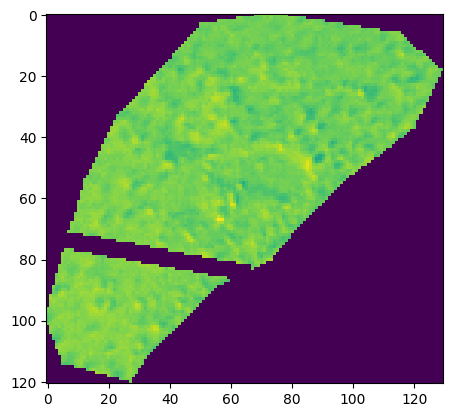

In [35]:
from copy import deepcopy
import random
from livecell_tracker.trajectory.contour_utils import get_cellTool_contour_points, viz_contours

def get_line_pixels(pt1, pt2, thickness=2, max_x=float("inf"), max_y=float("inf")):
    """get all pixel coordinates between two points

    Parameters
    ----------
    pt1 : _type_
        _description_
    pt2 : _type_
        _description_
    thickness : int, optional
        _description_, by default 3
    max_x : _type_, optional
        _description_, by default float("inf")
    max_y : _type_, optional
        _description_, by default float("inf")

    Returns
    -------
    _type_
        _description_
    """
    def _get_line_pixels_xy(x1, y1, x2, y2, max_x, max_y):
        # get the line equation
        if x1 == x2:
            m = 0
        else:
            m = (y2 - y1) / (x2 - x1)
        b = y1 - m * x1
        # get the pixels
        pixels = set()

        def add_xy(x, y):
            if y < max_y and x < max_x and y >= 0 and x >= 0:
                pixels.add((x, y))
            # simple thickening
            sx, sy = x - thickness, y - thickness
            for nx in range(sx, sx + thickness * 2):
                for ny in range(sy, sy + thickness * 2):
                    # if nx ny in bound
                    if nx >= 0 and ny >= 0 and nx < max_x and ny < max_y:
                        pixels.add((nx, ny))
        # exclude x2 purposely to follow skimage bbox conventions
        for x in range(x1, x2): 
            y = int(m * x + b)
            add_xy(x, y)
            y = int(m * x + b) + 1
            add_xy(x, y)
        return pixels
    x1, y1 = pt1
    x2, y2 = pt2
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    if x1 > x2:
        pt1, pt2 = pt2, pt1
        x1, y1, x2, y2 = x2, y2, x1, y1
    pixel_set1 = _get_line_pixels_xy(x1, y1, x2, y2, max_x, max_y)

    if y1 > y2:
        x1, y1, x2, y2 = x2, y2, x1, y1
    _pixel_set2 = _get_line_pixels_xy(y1, x1, y2, x2, max_y, max_x)
    pixel_set2 = set()
    for coord in _pixel_set2:
        pixel_set2.add((coord[1], coord[0]))
    return pixel_set1.union(pixel_set2)


def divide_single_cell_brute_force(sample_sc: SingleCellStatic, seg_crop, sampled_points=None):
    
    # get the contour points
    contour_points = sample_sc.get_contour_coords_on_img_crop()
    assert len(contour_points) >= 2, "need more than 2 contour points to divide a cell"
    if sampled_points is None:
        sampled_points = random.choices(contour_points, k=2)
        print("sampled_points:", sampled_points)

    pt1 = sampled_points[0]
    pt2 = sampled_points[1]

    # TODO remove the resample code below
    # # resample if the points are on the same vertical line
    # while pt1[0] == pt2[0] or pt1[1] == pt2[1]:
    #     sampled_points = random.choices(contour_points, k=2)
    #     pt1 = sampled_points[0]
    #     pt2 = sampled_points[1]

    line_pixels = np.array(list(get_line_pixels(pt1, pt2, max_x=seg_crop.shape[0], max_y=seg_crop.shape[1])), dtype=int)

    if len(line_pixels) == 0:
        print("[WARN] the sampled line pixels is empty, skipping division process...")
        return

    seg_crop[line_pixels[:, 0], line_pixels[:, 1]] = 0
    # get the center of mass of the contour
    center_of_mass = sample_sc
    
    # TODO: remove deepcopy because it creates underlying dataset objects holding paths as well
    new_sc = deepcopy(sample_sc)
    sample_sc.get_contour_img()


sampled_sc = single_cells[0]
# contour_points = sampled_sc.contour
# sampled_contour_points = contour_points[::3]
sc_img_path_substr = os.path.basename(sampled_sc.meta["path"]).split(".")[0]
seg_mask = seg_data.get_img_by_url(sc_img_path_substr, substr=True)
seg_crop = sampled_sc.gen_skimage_bbox_img_crop(sampled_sc.bbox, seg_mask)

sampled_sc.show_contour_mask()
plt.show()
# plt.imshow(seg_crop[:10, :])
# plt.show()

# print("contour points:", sampled_sc.get_contour_coords_on_img_crop())

# two test cases
sampled_points = [[ 85., 66.], [ 73., 0]]
# sampled_points = [[ 3., 50.], [ 3., 96.0]]
# sample_points = [[ 37., 120.], [54., 12.]]

contour_img = sampled_sc.get_contour_img()
divide_single_cell_brute_force(sampled_sc, seg_crop=contour_img, sampled_points=sampled_points)
# divide_single_cell_brute_force(sampled_sc, seg_crop=contour_img, sampled_points=None)
# get_line_pixels([1, 5], [10, 10])
# plt.imshow(seg_crop)
plt.imshow(contour_img)

Qualitatively generate and test bf more thoroughly...

In [36]:
def test_divide_bf():
    contour_img = sc.get_contour_img()
    divide_single_cell_brute_force(sc, seg_crop=contour_img, sampled_points=None)
    plt.imshow(contour_img)
    plt.show()

# for i in range(100):
#     test_divide_bf(sampled_sc)

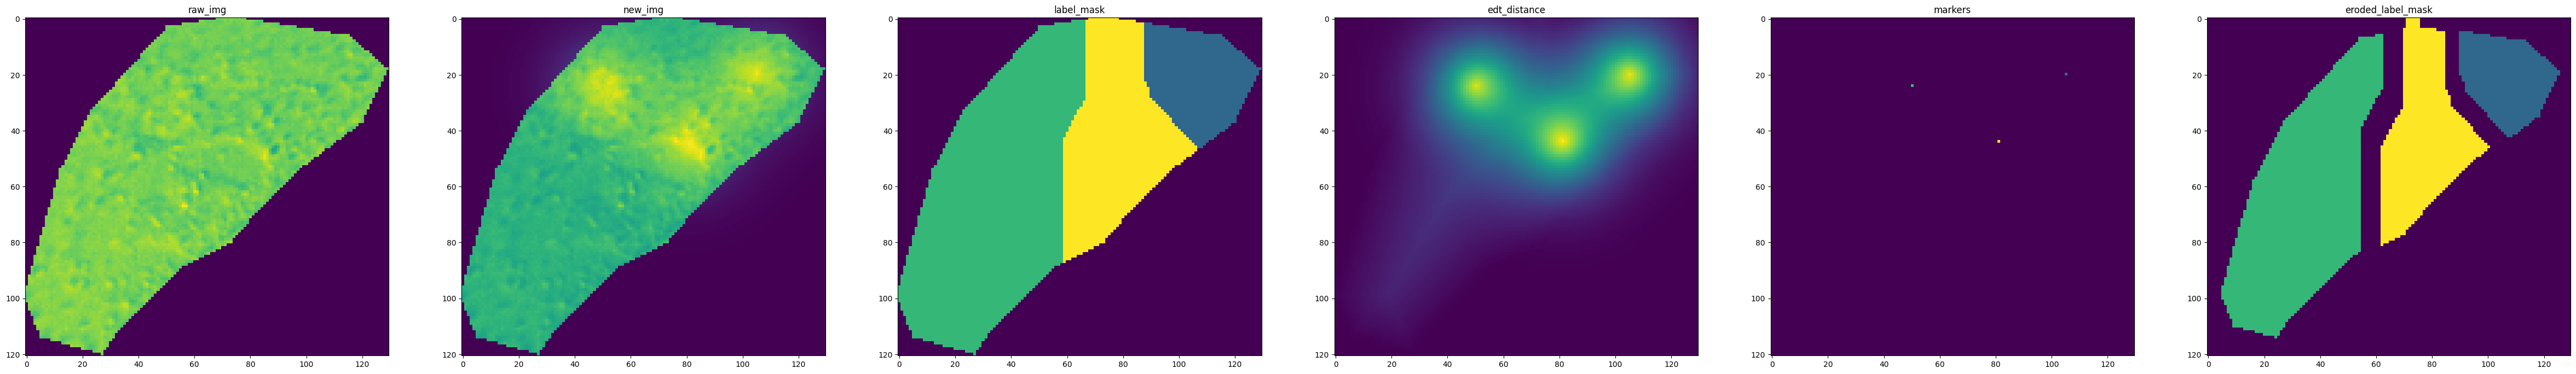

In [37]:
from scipy import ndimage
from skimage.segmentation import watershed
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.morphology import local_maxima, h_maxima
from skimage.measure import regionprops, label
import scipy.stats
import livecell_tracker

def add_random_gauss_to_img(contour_mask, raw_crop, square_len, gauss_center_val=200, gauss_std=8, inplace=False, pos=None):
    # add random gaussian noise to the raw image
    # randomly choose a point inside the contour
    if not inplace:
        raw_crop = raw_crop.copy()
    np.where(contour_mask > 0)
    cell_points =np.where(contour_mask > 0)

    # # double check: viz cell points from np
    # temp = np.zeros(contour_mask.shape)
    # temp[cell_points] = 1
    # plt.imshow(temp)
    # plt.title("temp")
    # plt.show()
    if pos is not None:
        rand_pt = pos
    else:
        rand_idx = np.random.randint(0, len(cell_points[0]))
        rand_pt = np.array([cell_points[0][rand_idx], cell_points[1][rand_idx]])

    # the mesh grid is the square around the random point
    x_min, x_max = max(rand_pt[0] - square_len, 0), min(rand_pt[0] + square_len, contour_mask.shape[0])
    y_min, y_max = max(rand_pt[1] - square_len, 0), min(rand_pt[1] + square_len, contour_mask.shape[1])
    grid = np.meshgrid(np.arange(x_min, x_max), np.arange(y_min, y_max))
    grid = np.stack(grid, axis=-1)


    # compute the distance between the random point and the mesh grid
    dist_to_center = np.linalg.norm(grid - rand_pt, axis=-1)


    # calculate the gaussian cdf  based on dist to center
    gaussian_cdf = scipy.stats.norm.cdf(-dist_to_center, loc=0, scale=gauss_std)

    # add gaussian noise to seg_crop
    raw_crop[x_min:x_max, y_min:y_max] += gaussian_cdf.T * gauss_center_val

    # print("cell_points:", cell_points)
    # print("cell_points len:", len(cell_points[0]))
    # print("contour mask sum:", contour_mask.sum())
    # print("square_len:", square_len)
    # print("grid shape:", grid.shape)
    # print("dist_to_center shape:", dist_to_center.shape)
    # print("dist_to_center mean:", np.mean(dist_to_center))
    # print("gaussian noise shape:", gaussian_cdf.shape)
    # print("gaussian mean:", np.mean(gaussian_cdf))
    return raw_crop, rand_pt



def divide_single_cell_watershed(sample_sc: SingleCellStatic, raw_crop=None, peak_distance=20, markers=None, marker_method="hmax", h_threshold=1, normalize=True, normalize_edt=True, gauss_center_val=200, edt_gauss_center_val=1, gauss_std=8, num_gauss_areas=2, return_all=False):
    contour_points = sample_sc.get_contour_coords_on_img_crop()
    contour_mask = sample_sc.get_contour_mask()
    
    if raw_crop is None:
        raw_crop = sample_sc.get_contour_img()
    else:
        raw_crop = raw_crop.copy()

    # normalize seg_crop
    if normalize:
        raw_crop = livecell_tracker.preprocess.utils.normalize_img_to_uint8(raw_crop)
        raw_crop = raw_crop.astype(float)

    # # print statistics of seg_crop
    # print("seg_crop shape:", raw_crop.shape)
    # print("seg_crop unique:", np.unique(raw_crop))
    # print("seg_crop mean:", np.mean(raw_crop))
    # print("cell area:", prop.area)
    # print("cell axis_major_length:", prop.major_axis_length)
    # print("cell axis_minor_length:", prop.minor_axis_length)

    # edt transform
    edt_distance = ndimage.distance_transform_edt(contour_mask)
    if normalize_edt:
        edt_flattened = edt_distance.flatten()
        edt_distance = (edt_distance - np.min(edt_flattened)) / (np.max(edt_flattened) - np.min(edt_flattened))
    # # print stats of edt_distance
    # print("edt_distance shape:", edt_distance.shape)
    # print("edt max:", np.max(edt_distance))
    # print("edt min:", np.min(edt_distance))
    # print("edt mean:", np.mean(edt_distance))
    # TODO: add gaussian noise

    # determin the area of noise (new labeled region for oversegmentation)
    assert len(np.unique(contour_mask)) == 2, "seg_crop should only contain one label"
    props = regionprops(label_image=contour_mask.astype(int), intensity_image=raw_crop)
    assert len(props) == 1, "seg_crop should only contain one label"
    prop = props[0]
    
    square_len = int(np.sqrt(prop.area))
    for _ in range(num_gauss_areas):
        _, rand_pos = add_random_gauss_to_img(contour_mask, raw_crop, square_len, gauss_center_val=gauss_center_val, gauss_std=gauss_std, inplace=True)
        add_random_gauss_to_img(contour_mask, edt_distance, square_len, gauss_center_val=edt_gauss_center_val, gauss_std=gauss_std, inplace=True, pos=rand_pos)

    # # show edt_distance
    # plt.imshow(edt_distance)
    # plt.title("edt_distance")
    # plt.show()
    # watershed segmentation
    if markers is None and marker_method == "hmax":
        # local_hmax = h_maxima(raw_crop, h_threshold)
        local_hmax = h_maxima(edt_distance, h_threshold)
        markers = label(local_hmax, connectivity=1)
    elif markers is None and marker_method == "local":
        # use local peak as default markers
        coords = peak_local_max(edt_distance, min_distance=peak_distance, footprint=np.ones((3, 3)))
        mask = np.zeros(edt_distance.shape, dtype=bool)
        mask[tuple(coords.T)] = True
        markers, _ = ndi.label(mask)

    # labels = watershed(edt_distance, markers, mask=contour_mask)
    label_mask = watershed(-edt_distance, markers, mask=contour_mask)

    # # print shapes
    # print("markers shape:", markers.shape)
    # print("markers unique values:", np.unique(markers))
    # print(np.where(markers > 0))
    
    # print("labels shape:", label_mask.shape)
    # print("labels unique values:", np.unique(label_mask))
    # plt.clf()
    # plt.imshow(label_mask)
    # plt.title("labels")
    # plt.show()
    if return_all:
        return raw_crop, label_mask, edt_distance, markers
    return label_mask


raw_crop = sampled_sc.get_contour_img()
# new_img, label_mask = divide_single_cell_watershed(sampled_sc, peak_distance=20, num_gauss_areas=4, marker_method="local", gauss_center_val=150)

new_raw_crop, label_mask, edt_distance, markers = divide_single_cell_watershed(sampled_sc, num_gauss_areas=3, marker_method="hmax", edt_gauss_center_val=10, gauss_std=16, h_threshold=1, return_all=True)

def erode_label_mask(label_mask: np.array, scale_factor=-0.1, bg_val=0):
    """Erode label mask to make each labeled region smaller and thus separated."""
    labels = np.unique(label_mask)
    # remove bg label
    labels = labels[labels != bg_val]

    res = np.zeros(label_mask.shape)
    for label in labels:
        bin_mask = label_mask == label
        bin_mask = bin_mask.astype(np.uint8)
        eroded_mask = dilate_or_erode_mask(bin_mask, scale_factor=scale_factor)
        res = res + eroded_mask * label
    return res

eroded_label_mask = erode_label_mask(label_mask, scale_factor=-0.1, bg_val=0)

fig, axes = plt.subplots(1, 6, figsize=(60, 10))
ax = axes[0]
ax.imshow(raw_crop)
ax.set_title("raw_img")
ax = axes[1]
ax.imshow(new_raw_crop)
ax.set_title("new_img")
ax = axes[2]
ax.imshow(label_mask)
ax.set_title("label_mask")
ax = axes[3]
ax.imshow(edt_distance)
ax.set_title("edt_distance")
ax = axes[4]
ax.imshow(markers)
ax.set_title("markers")
ax = axes[5]
ax.imshow(eroded_label_mask)
ax.set_title("eroded_label_mask")
plt.show()

### Generate synthetic data by watershed

In [38]:
def gen_synthetic_overseg(sc, num_samples=10, max_try=20, **kwargs):
    res_label_masks_and_params = []
    num_gauss_area = kwargs["num_gauss_areas"]
    for _ in range(num_samples):
        counter = 0
        num_segs = -1
        while num_segs < num_gauss_area and counter < max_try:
            label_mask = divide_single_cell_watershed(sc, **kwargs)
            num_segs = len(np.unique(label_mask)) - 1
            counter += 1
        if num_segs < num_gauss_area:
            # print("fail to generate enough segs")
            continue
        meta = kwargs.copy()
        meta["num_segs"] = num_segs
        eroded_label_mask = erode_label_mask(label_mask, scale_factor=-0.1, bg_val=0)
        res_label_masks_and_params.append((label_mask, eroded_label_mask, meta))
    return res_label_masks_and_params

overseg_uns_key = "overseg_imgs"
num_gauss_areas = np.arange(3, 6)
num_samples = 5

def process_sc_synthetic_overseg_crops(sc):
    sc.uns[overseg_uns_key] = []
    for num_gauss_area in num_gauss_areas:
        label_masks_and_params_hmax = gen_synthetic_overseg(sc, num_samples=num_samples, peak_distance=10, num_gauss_areas=num_gauss_area, marker_method="hmax", edt_gauss_center_val=10, gauss_std=16, h_threshold=1)
        label_masks_and_params_local = gen_synthetic_overseg(sc, num_samples=num_samples, peak_distance=10, num_gauss_areas=num_gauss_area, edt_gauss_center_val=10, gauss_std=16, marker_method="local",  gauss_center_val=150)
        sc.uns[overseg_uns_key].extend(label_masks_and_params_hmax)
        sc.uns[overseg_uns_key].extend(label_masks_and_params_local)
    return sc

from multiprocessing import Pool
pool = Pool()
res_single_cells = []
for res_sc in tqdm(pool.imap_unordered(process_sc_synthetic_overseg_crops, single_cells), total=len(single_cells)):
    res_single_cells.append(res_sc)
# pool.map(process_sc_synthetic_overseg_crops, single_cells)
pool.close()
pool.join()

100%|██████████| 294/294 [16:38<00:00,  3.39s/it]


In [39]:
single_cells = res_single_cells

In [40]:
# for i in range(5):
#     sc = single_cells[i]

#     # somehow failed to generate synthetic data meeting our criterion
#     if len(sc.uns[overseg_uns_key]) == 0:
#         continue
#     for j in range(len(sc.uns[overseg_uns_key])):
#         label_mask, eroded_label_mask, params = sc.uns[overseg_uns_key][j]
#         print(params)
#         fig, axes = plt.subplots(1, 2, figsize=(20, 10))
#         ax = axes[0]
#         ax.imshow(label_mask)
#         ax.set_title("label_mask")
#         ax = axes[1]
#         ax.imshow(eroded_label_mask)
#         ax.set_title("eroded_label_mask")
#         plt.show()

Remove overseg out directory contents if necessary
```# !rm -r $overseg_out_dir```

In [41]:
len(single_cells)
np.sum([len(sc.uns[overseg_uns_key]) for sc in single_cells])

5325

In [42]:
subdir = Path("synthetic_overseg")
overseg_out_dir = out_dir / subdir
raw_out_dir = overseg_out_dir / "raw"

# seg_out_dir is the directory containing all raw segmentation masks for training
# e.g. the eroded raw segmentation masks
seg_out_dir = overseg_out_dir / "seg"

# raw_seg_dir is the directory containing all raw segmentation masks for recording purposes
raw_seg_dir = overseg_out_dir / "raw_seg_crop"
gt_out_dir = overseg_out_dir / "gt"
gt_label_out_dir = overseg_out_dir / "gt_label_mask"
augmented_seg_dir = overseg_out_dir / "augmented_seg"
raw_transformed_img_dir = overseg_out_dir / "raw_transformed_img"
augmented_diff_seg_dir = overseg_out_dir / "augmented_diff_seg"
meta_path = overseg_out_dir / "metadata.csv"

os.makedirs(raw_out_dir, exist_ok=True)
os.makedirs(seg_out_dir, exist_ok=True)
os.makedirs(raw_seg_dir, exist_ok=True)
os.makedirs(gt_out_dir, exist_ok=True)
os.makedirs(augmented_seg_dir, exist_ok=True)
os.makedirs(gt_label_out_dir, exist_ok=True)
os.makedirs(raw_transformed_img_dir, exist_ok=True)
os.makedirs(augmented_diff_seg_dir, exist_ok=True)


overseg_train_path_tuples = []
augmented_overseg_data = []
filename_pattern = "img-%d_syn-%d.tif"
overseg_metadata = []
overseg_erosion_scale_factors = np.linspace(-0.1, 0, 10)
for sc in tqdm(single_cells):
    img_id = sc.timeframe
    for syn_id, overseg_datarow in enumerate(sc.uns[overseg_uns_key]):
        params = overseg_datarow[1]
        img_crop = sc.get_contour_img()
        raw_seg_crop = overseg_datarow[0]
        eroded_seg_crop = overseg_datarow[1]

        combined_gt_label_mask = sc.get_contour_mask()
        assert img_crop.shape == raw_seg_crop.shape == combined_gt_label_mask.shape
        raw_img_path = raw_out_dir / (filename_pattern % (img_id, syn_id))
        seg_img_path = seg_out_dir / (filename_pattern % (img_id, syn_id))
        raw_seg_img_path = raw_seg_dir / (filename_pattern % (img_id, syn_id))
        gt_img_path = gt_out_dir / (filename_pattern % (img_id, syn_id))
        gt_label_img_path = gt_label_out_dir / (filename_pattern % (img_id, syn_id))

        # metadata is a dict, containing params used to genereate our synthetic overseg data
        meta_info = overseg_datarow[2]
        meta_info["raw_img_path"] = raw_img_path
        meta_info["seg_img_path"] = seg_img_path
        meta_info["gt_img_path"] = gt_img_path
        
        overseg_metadata.append(meta_info)

        # call csn augment helper
        csn_augment_helper(img_crop=img_crop, 
            seg_crop=eroded_seg_crop, 
            combined_gt_label_mask=combined_gt_label_mask,
            overseg_raw_seg_crop=raw_seg_crop,
            overseg_raw_seg_img_path=raw_seg_img_path,
            scale_factors=overseg_erosion_scale_factors,
            train_path_tuples=overseg_train_path_tuples,
            augmented_data=augmented_overseg_data,
            img_id=img_id,
            seg_label=syn_id,
            gt_label=sc.timeframe,
            raw_img_path=raw_img_path,
            seg_img_path=seg_img_path,
            gt_img_path=gt_img_path,
            gt_label_img_path=gt_label_img_path,
            augmented_seg_dir=augmented_seg_dir,
            augmented_diff_seg_dir=augmented_diff_seg_dir,
            filename_pattern=filename_pattern,
        )


100%|██████████| 294/294 [07:53<00:00,  1.61s/it]


In [43]:
pd.DataFrame(
    overseg_train_path_tuples,
    columns=["raw", "seg", "gt", "raw_seg", "scale", "aug_diff_mask", "gt_label_mask", "raw_transformed_img"],
).to_csv(overseg_out_dir / "data.csv", index=False)

pd.DataFrame(
    overseg_metadata,
).to_csv(meta_path, index=False)


## Combine data.csv files generated in each data folder

In [44]:
dataframes = []
for subdir in out_dir.iterdir():
    if subdir.is_dir():
        data_path = subdir / "data.csv"
        dataframe = pd.read_csv(data_path)
        dataframe["subdir"] = subdir.name
        dataframes.append(dataframe)
combined_dataframe = pd.concat(dataframes)
combined_dataframe.to_csv(out_dir / "train_data.csv", index=False)

In [45]:
len(combined_dataframe)

53810

In [46]:
combined_dataframe[:2]

,raw,seg,gt,raw_seg,scale,aug_diff_mask,gt_label_mask,raw_transformed_img,subdir
0,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,-0.100000,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,synthetic_overseg
1,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,-0.088889,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,notebook_results/a549_ccp_vim/train_data_v5/sy...,synthetic_overseg


In [47]:
def match_overseg_mask_labels(mask: np.array, sc: SingleCellStatic, io_seg_threshold=0.6):
    """match a single cell's label in a mask. sc must contain its contour information.

    Parameters
    ----------
    mask : np.array
        _description_
    sc : 
        _description_

    Returns
    -------
    a dict with keys "seg_label" and "iou"
    """    
    cropped_seg_mask = SingleCellStatic.gen_skimage_bbox_img_crop(sc.bbox, seg_mask)

    # Note the order of the arguments are reversed compared with underseg case
    # because match_mask_labels_by_iou is designed to match one seg mask to several gt masks (select gt sc's best matching seg label)
    # and in the oversegmentation case, we need to match one gt mask to several seg masks
    _, seg2gt_info = match_mask_labels_by_iou(seg_mask=sc.get_contour_mask(), gt_mask=cropped_seg_mask, return_all=True)
    matched_seg_labels = []
    for info in seg2gt_info:
        seg_label = info["seg_label"]
        iou = info["iou"]
        # Not the code below is not a bug: remember we reverse the order of the arguments
        io_gt = info["io_seg"]
        io_seg = info["io_gt"]
        if io_seg > io_seg_threshold:
            matched_seg_labels.append(seg_label)
    return matched_seg_labels

for sc in tqdm(single_cells):
    sc_img_path_substr = os.path.basename(sc.meta["path"]).split(".")[0]
    seg_mask = seg_data.get_img_by_url(sc_img_path_substr, substr=True)
    sc.meta["overseg_labels"] = match_seg_mask_label(seg_mask, sc)["seg_label"]
    sc.mask_dataset = seg_data

100%|██████████| 294/294 [00:11<00:00, 24.75it/s]


## TODO Below: adapt to new code

In [48]:
(img_crop, seg_crop, combined_mask, aug_mask, aug_diff_mask, combined_gt_label_mask, raw_transformed_img_crop) = augmented_data[(1, 14)][0]

TypeError: list indices must be integers or slices, not tuple

In [ ]:
np.unique(combined_mask), np.unique(aug_mask)

In [ ]:
import matplotlib.patches as mpatches

mask_tuples = list(augmented_overseg_data.values())[0]
nsamples = 10
# nsamples = np.sum([len(v) for v in augmented_data.values()])
ncol = 7
fig, axes = plt.subplots(nsamples, ncol, figsize=(25, 5.5 * nsamples))
fig.tight_layout()

sample_counter = 0
for key, mask_tuples in augmented_overseg_data.items():
    for j in range(len(mask_tuples)):
        i = sample_counter
        axes[i, 0].imshow(mask_tuples[j][0])
        axes[i, 0].set_title("raw mask")
        axes[i, 1].imshow(mask_tuples[j][1])
        axes[i, 1].set_title("seg img")
        axes[i, 2].imshow(mask_tuples[j][2])
        axes[i, 2].set_title("combined mask")
        axes[i, 3].imshow(mask_tuples[j][3])
        axes[i, 3].set_title("augmented mask")
        im = axes[i, 4].imshow(mask_tuples[j][4])
        axes[i, 4].set_title("augmented diff mask")

        values = np.unique(mask_tuples[j][4])
        colors = [ im.cmap(im.norm(value)) for value in values]
        patches = [ mpatches.Patch(color=colors[i], label="Level {l}".format(l=values[i]) ) for i in range(len(values)) ]
        axes[i, 4].legend(handles=patches, loc=2, borderaxespad=0. )

        axes[i, 5].imshow(mask_tuples[j][5])
        axes[i, 5].set_title("combined gt label mask")

        axes[i, 6].imshow(mask_tuples[j][6])
        axes[i, 6].set_title("raw transformed img")

        sample_counter += 1
        if sample_counter >= nsamples:
            break
    if sample_counter >= nsamples:
        break

Deprecated code for augmenting a single cell for CSN
```
from pathlib import Path
from copy import deepcopy
from PIL import Image, ImageSequence

img_paths = []
augment_dir = Path("../datasets/a549_ccnn/augmented_cells")
augmented_cells = []
scale_factor = 0.01
padding = 100

def augment_single_cell_csn(sc: SingleCellStatic, augment_dir: Path, scale_factor=0.01, padding=40, show=False, bg_value=0):
    mask = sc.get_mask_crop(padding=padding).astype(np.uint8)
    mask_label = sc.meta["seg_label"]
    mask[mask!=mask_label] = bg_value

    augmented_mask = dilate_or_erode_mask(mask, scale_factor=scale_factor)
    augmentation_save_path = augment_dir / f"{i}_mask.tif"
    save_png(augmented_mask, str(augmentation_save_path))

    meta = {}
    meta["original_path"] = sc.meta["path"]
    meta["original_seg_label"] = sc.meta["seg_label"]
    meta["path"] = augmentation_save_path.as_posix()
    meta["padding"] = padding
    meta["scale_factor"] = scale_factor
    meta["method"] = "dilate/erode"

    new_sc = SingleCellStatic(
        img_dataset=sc.img_dataset,
        mask_dataset=sc.mask_dataset,
        contour = np.array(sc.contour),
        meta=meta,
    )

    if show:
        fig, axes = plt.subplots(1, 4, figsize=(10, 10))
        # sc.show_mask(ax=axes[0])
        sc.show(ax=axes[0])
        axes[2].imshow(mask)
        sc.show_contour_img(ax=axes[1])
        axes[3].imshow(augmented_mask)

        axes[0].set_title("original image crop")
        axes[2].set_title("seg mask")
        axes[1].set_title("gt contour mask")
        axes[3].set_title("augmented mask")
    return new_sc


augmented_single_cells = []
for i in tqdm(range(len(single_cells))):
    sc = single_cells[i]
    augmented_sc = augment_single_cell_csn(sc, augment_dir, scale_factor=scale_factor, padding=padding, show=False)
    augmented_single_cells.append(augmented_sc)
```


Undersegmentation case:
    overlay all the ground truth masks on the original image, and then use the result as the ground truth mask for the undersegmentation case.
    Segmentation mask 
    gt mask

OVERSEGMENTATION CASE:
    # future work
    Segmentation mask
    gt mask


1. Overlay segmentation mask and gt mask
2. Shift the cells in the segmentation mask to the center of the cell
3. Synthetic dataset

thin_plate_spline?